In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_dir="/content/drive/MyDrive/Pet_Breeds/Pet_Breeds"

### Load data 

In [5]:
generator =ImageDataGenerator(
                                   rescale=1. /255,
                                   rotation_range=40 , 
                                   width_shift_range=.2 , 
                                   height_shift_range=.2 , 
                                   zoom_range=.2 , 
                                   shear_range=.2,
                                   fill_mode='nearest', 
                                   horizontal_flip=True,
                               validation_split=0.2
)

In [6]:
train_generator = generator.flow_from_directory(data_dir  , 
                                                    batch_size=10 , 
                                                    subset="training",
                                                    class_mode='categorical',
                                                    target_size=(150 , 150)
)

validation_generator =generator.flow_from_directory(data_dir,
                                                             subset="validation",
                                                             batch_size=10 , 
                                                             class_mode='binary',
                                                             target_size=(150 , 150)
                                                            )



Found 3105 images belonging to 23 classes.
Found 776 images belonging to 23 classes.


In [7]:
path_inception = "/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model =InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
   
# Print the model summary
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Obtain last layer output of the pre-trained model

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [9]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True


In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1 , activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics =['accuracy'])

model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
from tensorflow.keras.utils import plot_model

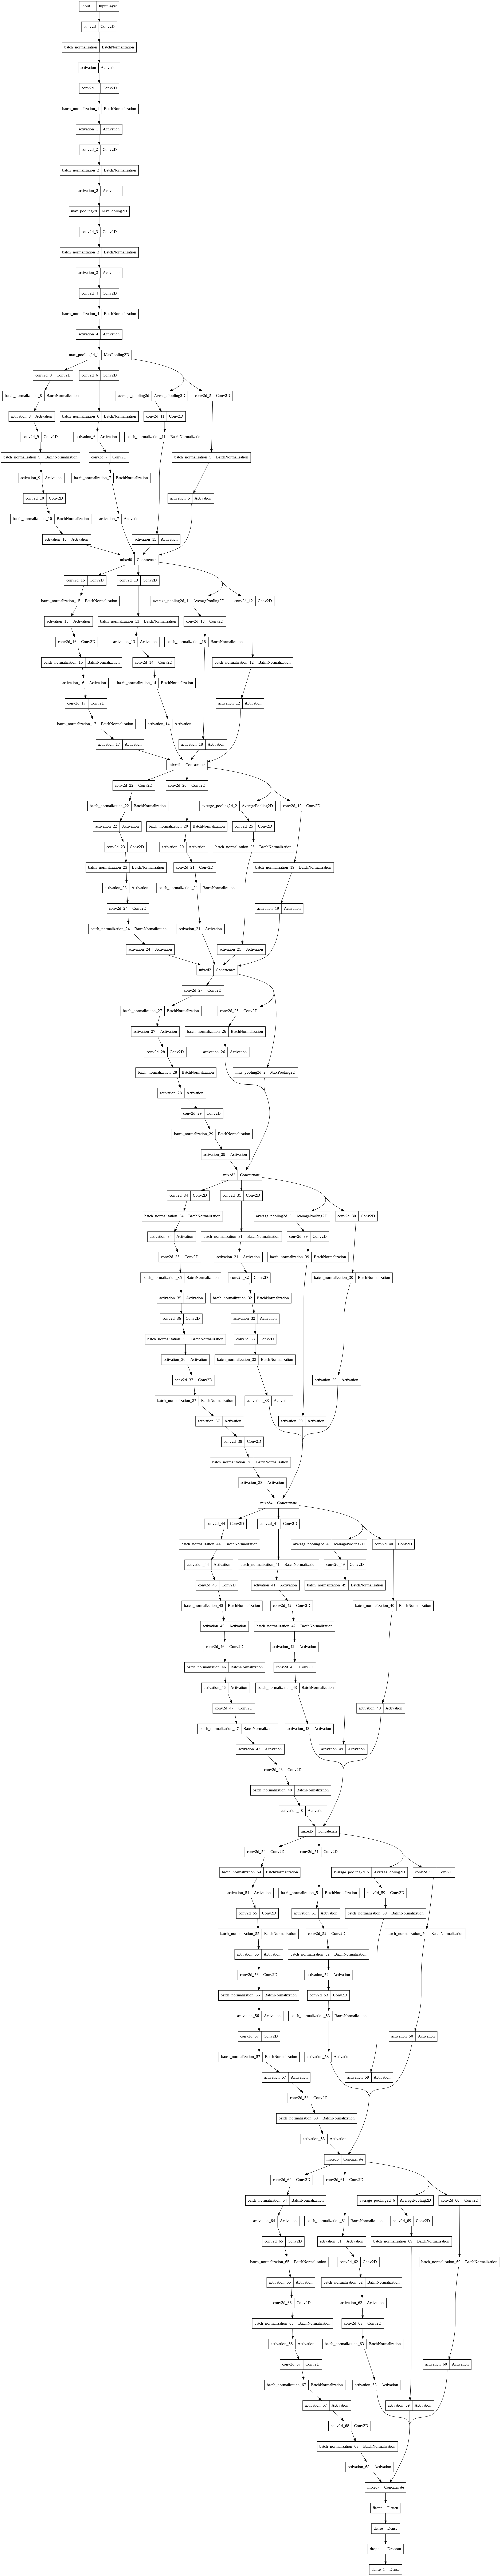

In [12]:
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False , show_layer_names=True)